# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.figure import Figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo1'
    model_path = f"/media/{machine_path.split('/')[-1]}/{external_media}"

Tp = 1350
# Tp = 1400

# Hlit = 80
Hlit = 120

print(f"Tp: {Tp} oC, Hlit: {Hlit} km")
if(Tp == 1350):
    if(Hlit == 80):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v05/RFT_Tp1350_v05",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v1/RFT_Tp1350_v1",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v2/RFT_Tp1350_v2",
                    ]
    if(Hlit == 120):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1350_v05_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1350_v1_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1350_v2_lit120km",
                    ]
if(Tp == 1400):
    if(Hlit == 80):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v05/RFT_Tp1400_v05",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v1/RFT_Tp1400_v1",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/v2/RFT_Tp1400_v2",
                    ]
    if(Hlit == 120):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v05/RFT_Tp1400_v05_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v1/RFT_Tp1400_v1_lit120km",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/v2/RFT_Tp1400_v2_lit120km",
                    ]

plot_isotherms = True
plot_melt = True
# plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
             'temperature_anomaly',
             'surface',
             'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True
if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in properties):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')
# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('melt' not in properties):
        properties.append('melt')
    if ('incremental_melt' not in properties):
        properties.append('incremental_melt')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('melt')
    to_remove.append('incremental_melt')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max

Tp: 1350 oC, Hlit: 120 km


In [3]:
properties, new_datasets

(['lithology', 'strain_rate', 'temperature_anomaly', 'surface', 'viscosity'],
 ['strain',
  'density',
  'strain_rate',
  'temperature',
  'surface',
  'viscosity',
  'melt',
  'incremental_melt'])

RFT_Tp1350oC_vel_comparison_hlit120km_lithology


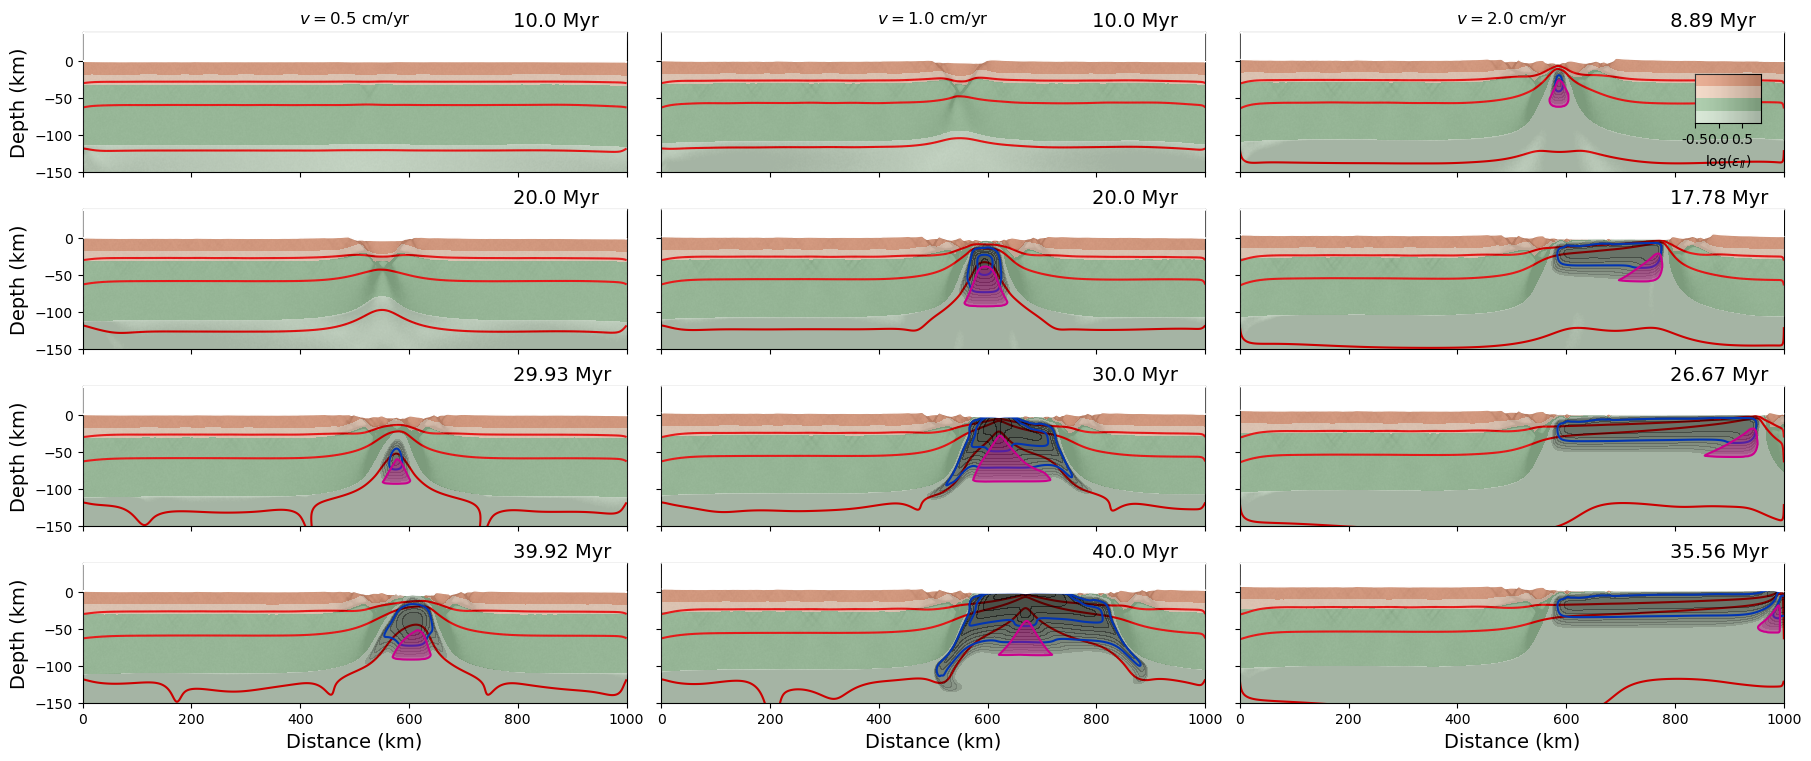

In [4]:

##############################################################################################################
#Creating path to the experiment

# fpath = machine_path + scenario
# print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [10, 20, 30, 40] #Myr
else:
    instants = [10, 20, 30, 40] #Myr

##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18, fig_height), sharex=False, sharey=True)
else:
    fig, axs = plt.subplots(len(instants), 3, constrained_layout=True, figsize=(18,4), sharex=False, sharey=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
zoom_uc = True
# zoom_uc = False

Lcraton = 0 
# Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-150, 40]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [0, float(dataset0.isel(time=i).lx)/1.0e3]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.0, 1.0]
        # ylims = [-5, 5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False
        
    plot_particles = True
    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[3*i],
             plot_isotherms = plot_isotherms,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             plot_melt = plot_melt,
             # melt_method = melt_method,
            )

    plot_property(dataset1.isel(time=idx), prop, xlims, ylims, scenarios[1],
            fig,
            axs[3*i+1],
            plot_isotherms = plot_isotherms,
            plot_particles = False,
            particle_size = 0.2,
            particle_marker = ".",
            ncores = 20,
            #  step_plot = 4,
            isotherms = [500, 800, 1300],
            plot_colorbar=False,
            plot_melt = plot_melt,
            # melt_method = melt_method,
            )

    plot_property(dataset2.isel(time=idx), prop, xlims, ylims, scenarios[2],
                fig,
                axs[3*i+2],
                plot_isotherms = plot_isotherms,
                plot_particles = False,
                particle_size = 0.2,
                particle_marker = ".",
                ncores = 20,
                # step_plot = 4,
                isotherms = [500, 800, 1300],
                plot_colorbar=plot_colorbar,
                plot_melt = plot_melt,
                # melt_method = melt_method,
                )
    
# axs[0].set_title(r'CKR')
# axs[1].set_title(r'CKS')
        
# axs[1].set_title(r'CKMD0.01')

axs[0].set_title(r'$v=0.5$ cm/yr')
axs[1].set_title(r'$v=1.0$ cm/yr')
axs[2].set_title(r'$v=2.0$ cm/yr')


label_fsize = 14
for i in range(len(instants)):
    # axs[2*i].set_title(f"{letters[i]} - {instants[i]} Myr")
    # axs[2*i+1].set_title(f"{letters[i]} - {instants[i]} Myr")
    axs[3*i].set_ylabel('Depth (km)', fontsize=label_fsize)

    if(i == len(instants) - 1):
        axs[3*i].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+1].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[3*i+2].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[3*i].set_xticklabels([])
        axs[3*i+1].set_xticklabels([])
        axs[3*i+2].set_xticklabels([])


figname = f"RFT_Tp{Tp}oC_vel_comparison_hlit{Hlit}km_{prop}"
print(f'{figname}')

fig.savefig(f"out/plots/{figname}.png", dpi=200)
fig.savefig(f"out/plots/{figname}.pdf", dpi=200)

RFT_Tp1400oC_vel_comparison_lithology


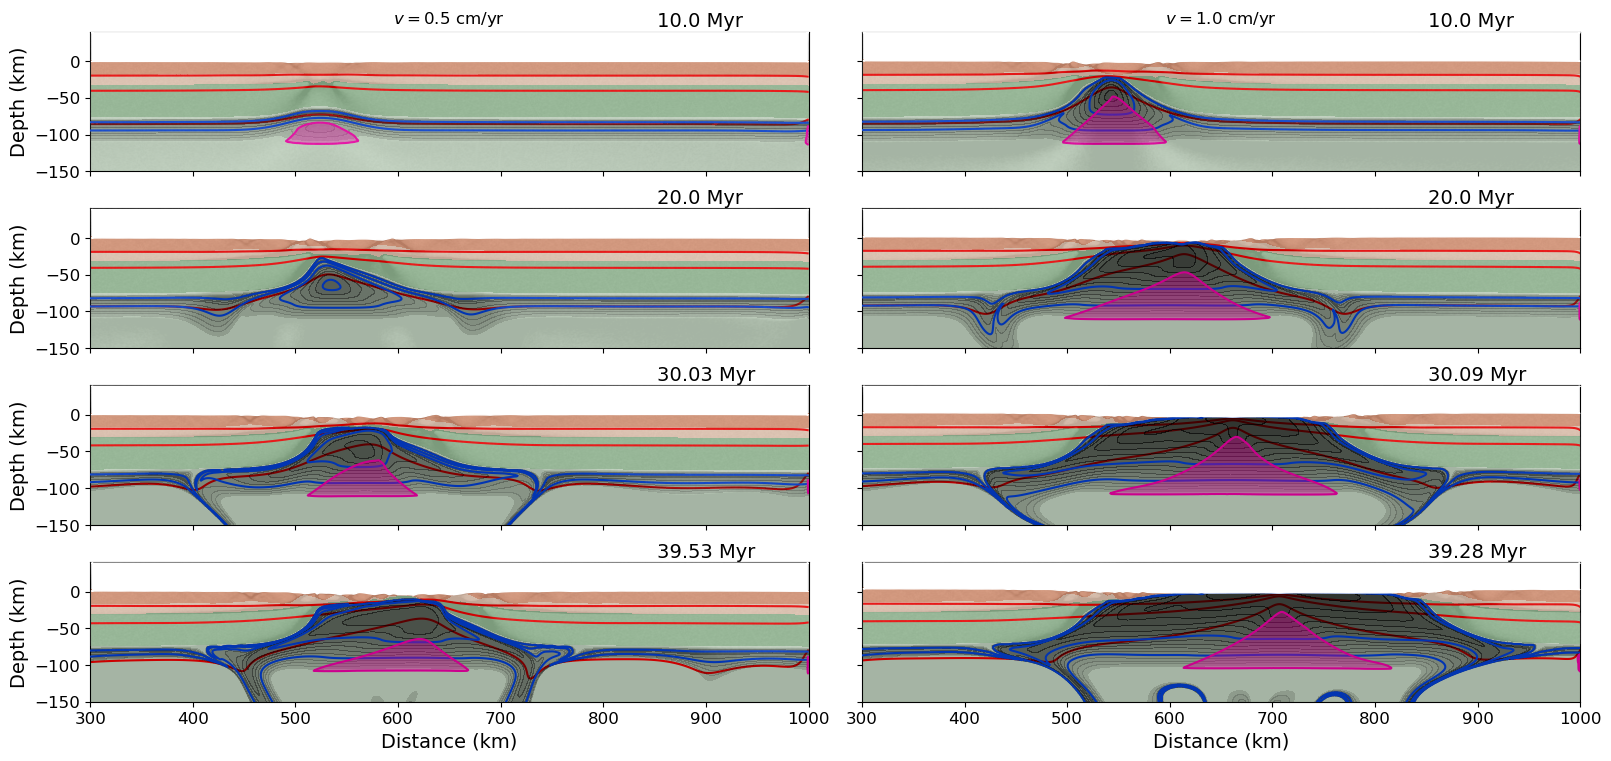

In [28]:

##############################################################################################################
#Creating path to the experiment

# fpath = machine_path + scenario
# print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

##############################################################################################################
#Set instants
if(prop != 'surface'):
    instants = [10, 20, 30, 40] #Myr
else:
    instants = [10, 20, 30, 40] #Myr

##############################################################################################################
#Creating figure and subplots
plt.close()
# gridspec_kw={'height_ratios':[0.3,0.5]}

if(len(instants) > 1):
    fig_height = (3.0/2.0)*(len(instants) + 1) #6 minimum
#     fig_height = (2.0)*(len(instants) + 1) #4 is minimum

    fig, axs = plt.subplots(len(instants), 2, constrained_layout=True, figsize=(16, fig_height), sharex=False, sharey=True)
else:
    fig, axs = plt.subplots(len(instants), 2, constrained_layout=True, figsize=(16, 4), sharex=False, sharey=True)
axs = axs.flatten() #flatten the axs array to make it easier to iterate over the subplots

alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

i = 0
zoom_uc = True
# zoom_uc = False

Lcraton = 1200.0

if(prop != 'surface'): # you can customize
    if(zoom_uc):
        xlims = xlims = [300, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-150, 40]
        # plot steps
        plot_particles = True
    else:
        xlims = [0, float(dataset0.isel(time=i).lx) / 1.0e3]
        ylims = [-float(dataset0.isel(time=i).lz) / 1.0e3 + 40, 40]
        # plot steps
        plot_particles = False
        print(xlims, ylims)
else: #for surface plot
    if(zoom_uc):
        xlims = [float(dataset0.isel(time=i).lx)/2.0e3 - Lcraton/2 - 150, float(dataset0.isel(time=i).lx)/2.0e3 + Lcraton/2 + 150]
        ylims = [-1.0, 1.0]
        
    else:
        xmin = 0 #+ 200
        xmax = float(dataset0.isel(time=i).lx) / 1.0E3 #- 200
        xlims = [xmin, xmax]
        ylims = [-1.0, 1.0]
        # ylims = [-5, 5]

for instant, i in zip(instants, range(len(instants))):
    idx = find_nearest(dataset0.time, instant)
    if(instant == instants[0]):
        plot_colorbar = True
    else:
        plot_colorbar = False
        
    plot_particles = True
    plot_property(dataset0.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[2*i],
             plot_isotherms = plot_isotherms,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=False,
             plot_melt = plot_melt,
            )

    plot_property(dataset1.isel(time=idx), prop, xlims, ylims, scenarios[1],
            fig,
            axs[2*i+1],
            plot_isotherms = plot_isotherms,
            plot_particles = False,
            particle_size = 0.2,
            particle_marker = ".",
            ncores = 20,
            #  step_plot = 4,
            isotherms = [500, 800, 1300],
            plot_colorbar=False,
            plot_melt = plot_melt,
            )

axs[0].set_title(r'$v=0.5$ cm/yr')
axs[1].set_title(r'$v=1.0$ cm/yr')


label_fsize = 14
for i in range(len(instants)):
    axs[2*i].set_ylabel('Depth (km)', fontsize=label_fsize)

    if(i == len(instants) - 1):
        axs[2*i].set_xlabel('Distance (km)', fontsize=label_fsize)
        axs[2*i+1].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[2*i].set_xticklabels([])
        axs[2*i+1].set_xticklabels([])


figname = f"RFT_Tp{Tp}oC_vel_05vs1_comparison_hlit{Hlit}km_{prop}"
print(f'{figname}')

fig.savefig(f"out/plots/{figname}.png", dpi=200)
fig.savefig(f"out/plots/{figname}.pdf", dpi=200)